In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import sqlite3
from datetime import datetime
import numpy as np
import seaborn as sns

from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesResampler
from visualization import visualize
from clustering import KMeans, MyKernelKMeans, visualize_clusters, visualize_kernel_kmeans

sns.set()

In [2]:
SEED = 42
np.random.seed(SEED)

In [3]:
con = sqlite3.connect('data/trade_info.sqlite3')
trading_session = pd.read_sql('SELECT * FROM Trading_session', con)
chart_data = pd.read_sql('SELECT * FROM Chart_data', con)
con.close()

In [4]:
trading_session["date"] = pd.to_datetime(trading_session["date"], format="%Y-%m-%d")
trading_session = trading_session[trading_session.trading_type == "monthly"]

chart_data["time"] = pd.to_datetime(chart_data["time"], format="%H:%M:%S")

chart_data["time"] = chart_data["time"].apply(lambda x: datetime(x.year, x.month, x.day, 0, x.minute, x.second))

In [5]:
"""
тут мы выкинули совсем оставшийся выброс, когда сделка совершена совсем поздно (благо, после джойна она одна)
"""

chart_data = chart_data[chart_data.time < datetime(1900, 1, 1, 17, 0, 0)]

In [6]:
"""
Оставляем только валидный договор
"""

chart_data.sort_values("time").drop_duplicates(subset="deal_id", inplace=True)

In [7]:
data = chart_data.join(trading_session.set_index("id"), on="session_id", how="inner")

In [8]:
data["datetime"] = data.apply(lambda x: datetime(x.date.year, x.date.month, x.date.day, x.time.hour, x.time.minute, x.time.second), axis=1)
data.sort_values("datetime", inplace=True)  # sort in historical order

In [9]:
"""
Выбросим уже не нужные колонки
"""

data.drop(["date", "trading_type", "deal_id", "id", "datetime"], axis=1, inplace=True)

In [10]:
"""
Нормализуем цены в рамках сессий
"""

data["price_norm"] = data.groupby("session_id")["price"].transform(lambda x: (x - x.mean()) / x.std()).fillna(0)

# Visualization

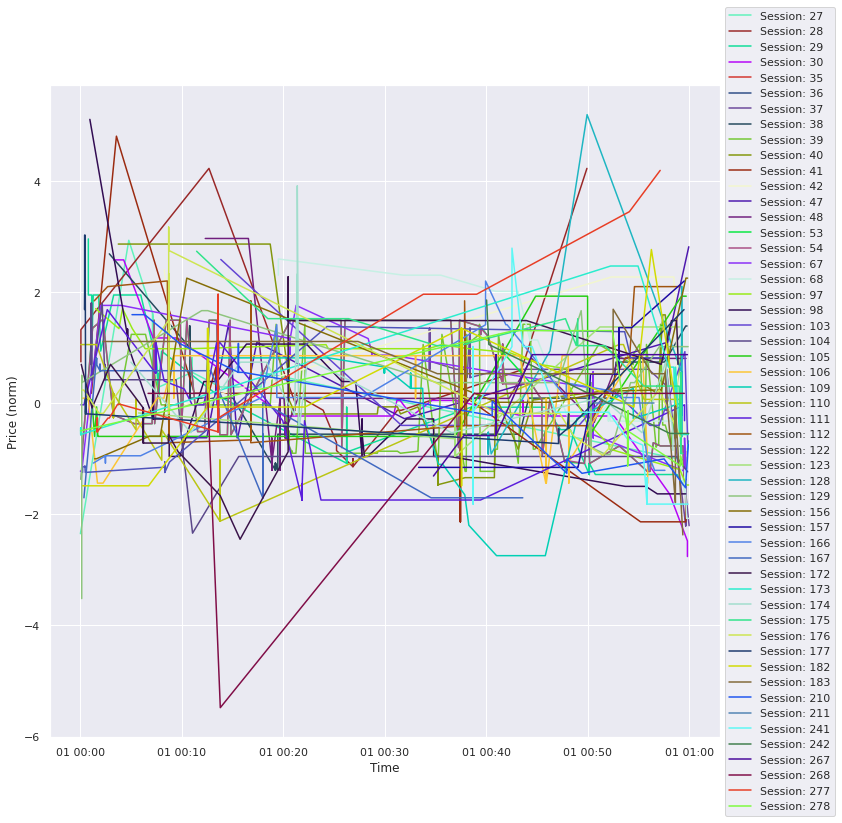

In [11]:
visualize(data)

Это абстракционизм!

In [12]:
"""
Выбросим сессии, в которых было мало сделок, 
так как в них очень плотные точки -- дают малое представление о всей сессии в сравнении с другими
"""

msk = data.session_id.value_counts()

data = data[data.session_id.isin(msk[msk >= 30].index)]
data_prep = data.copy()

In [13]:
"""
Добавим фиктивные начала и конец дня, чтобы ресемплить в дальнейшем к одной длине по всему дню
"""

others = []

for ses in data.session_id.unique():
    plat = data[data.session_id == ses].platform_id.values[0]
    others.append(
        pd.DataFrame({
            "time": [datetime(1900, 1, 1, 0, 0, 0), datetime(1900, 1, 1, 0, 59, 0)],
            "lot_size": [0, 0],
            "session_id": [ses, ses],
            "price": [0, 0],
            "price_norm": [0, 0],
            "platform_id": plat
            })
        )
    
data_prep = data_prep.append(others).reset_index()

In [14]:
data_prep = data_prep.groupby("session_id").resample("1T", on="time").mean().interpolate("linear").drop(columns="session_id").reset_index().drop("index", axis=1)

In [15]:
data_prep["platform_id"] = data_prep["platform_id"].apply(int)

# Visualization after preprocessing

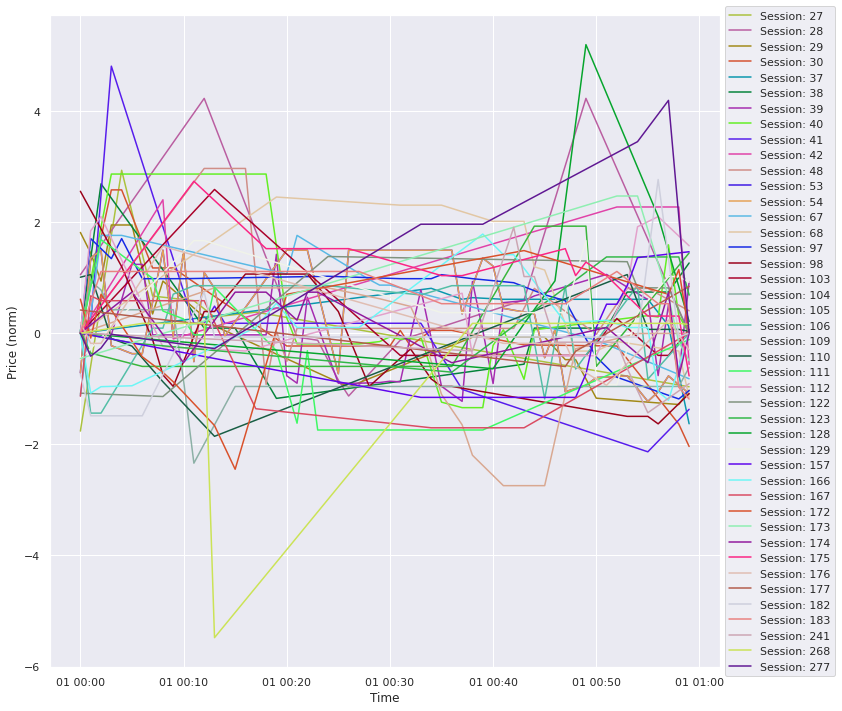

In [16]:
visualize(data_prep)

# Clustering

In [17]:
"""
Будем смотреть на нормированную цену в качественно значений временного ряда,
к этому моменту все данные имеют одну временную длину
"""

feature = "price_norm"
n = 8
n_init = 10

Составим датасеты из временных рядом, будем использовать либу `tslearn`

In [18]:
ts = []

for session_id, values in data.groupby("session_id")[feature]:
    if values.shape[0] > 1:
        ts.append(values.tolist())
    
train = to_time_series_dataset(ts)
train = TimeSeriesResampler(sz=train.shape[1]).fit_transform(train)

train_eucl = np.nan_to_num(train, 0)

In [19]:
ts = []

for session_id, values in data_prep.groupby("session_id")[feature]:
    ts.append(values.tolist())
    
train_prep = to_time_series_dataset(ts)

# Euclidean

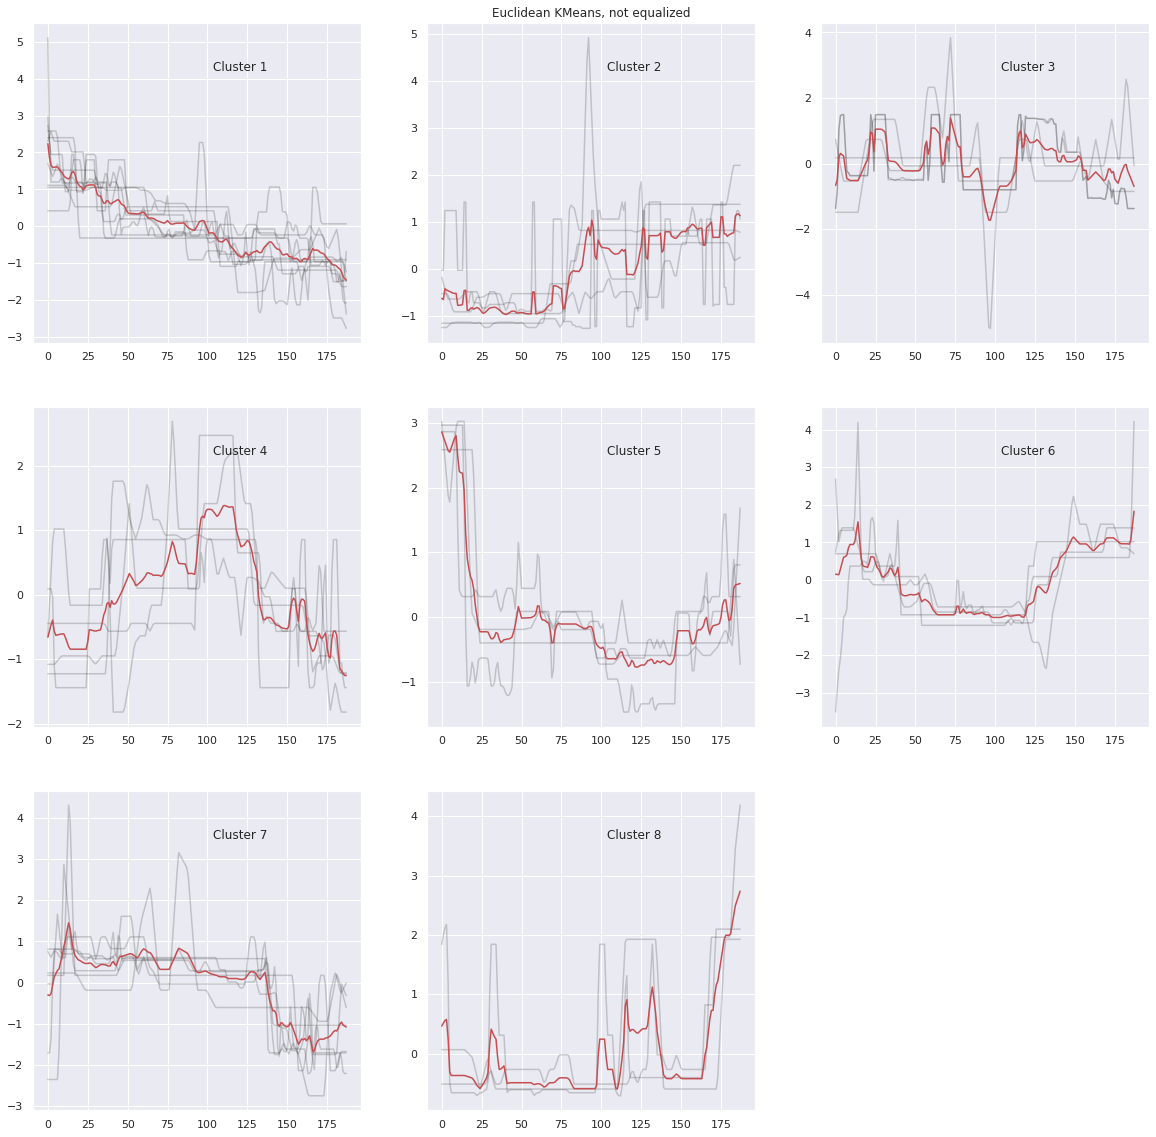

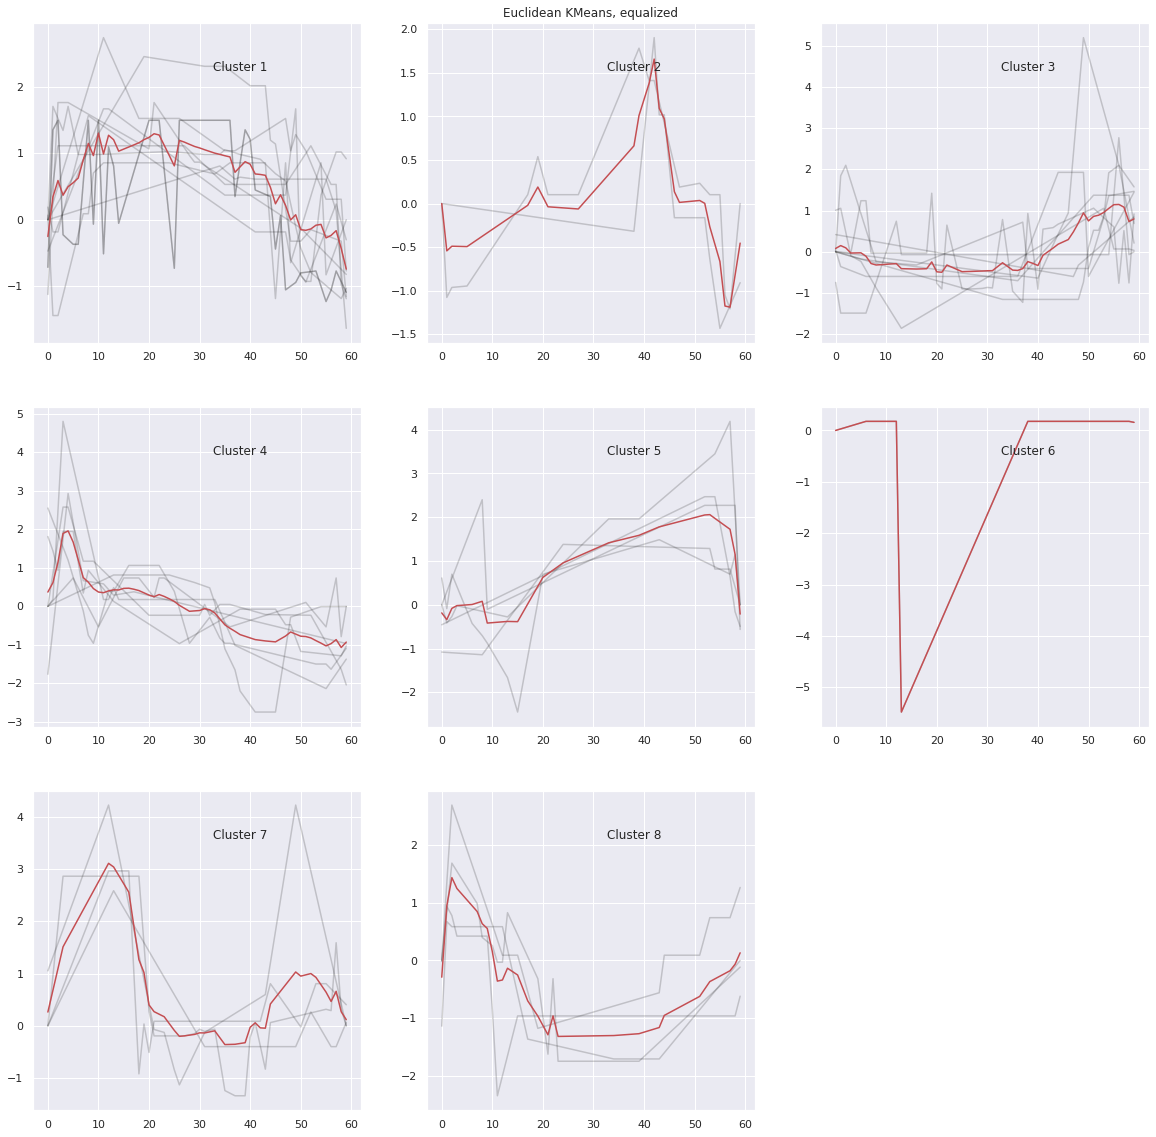

In [20]:
km, y_pred = KMeans(train_eucl, n, "euclidean", n_init, SEED)
km_prep, y_pred_prep = KMeans(train_prep, n, "euclidean", n_init, SEED)

visualize_clusters(km, train_eucl, y_pred, title="Euclidean KMeans, not equalized")
visualize_clusters(km_prep, train_prep, y_pred_prep, title="Euclidean KMeans, equalized")

# DTW

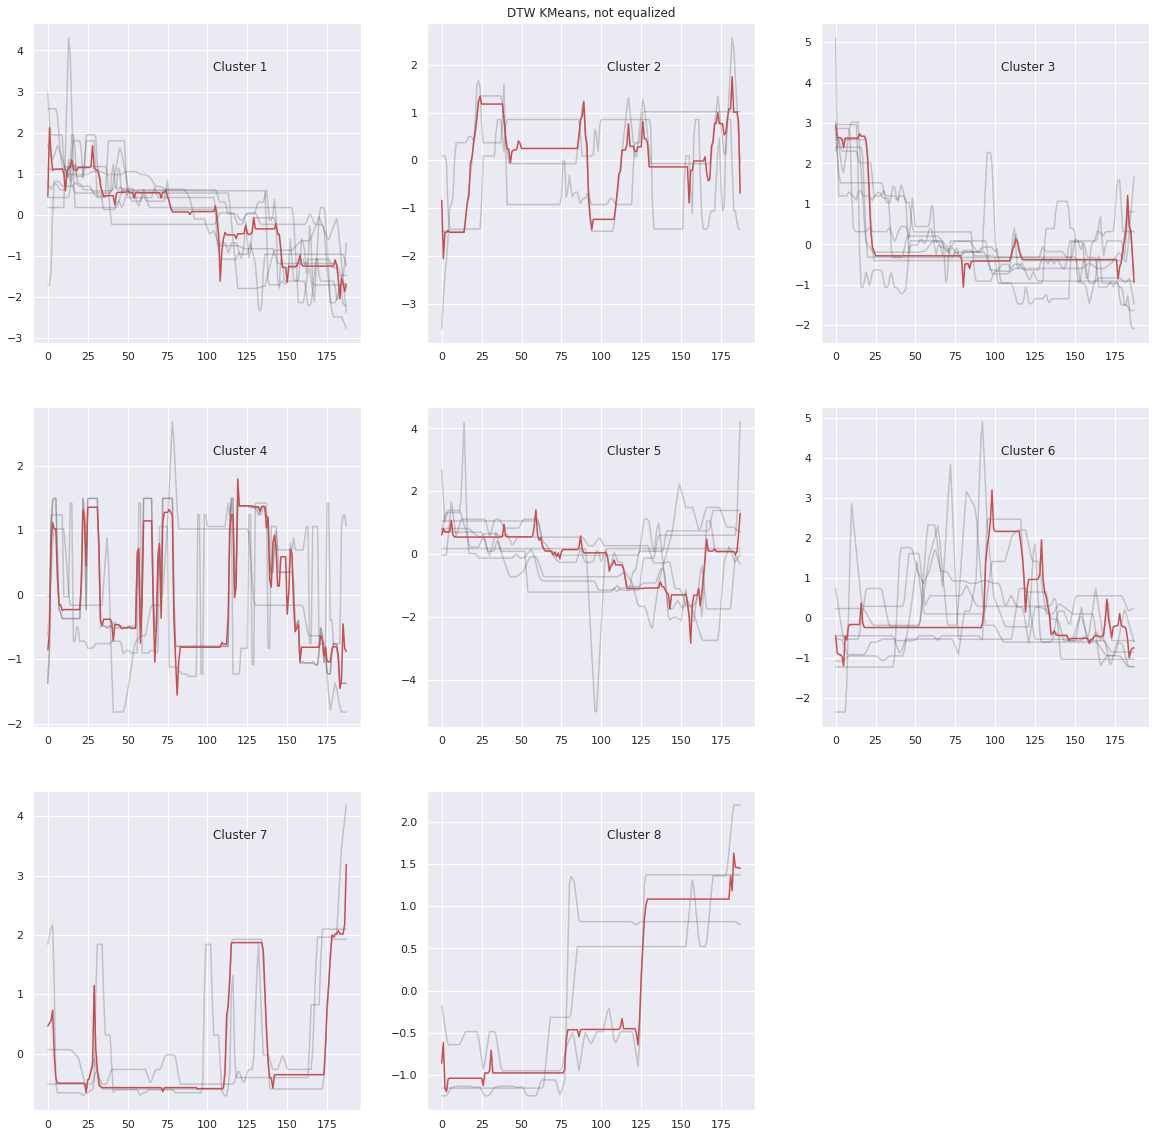

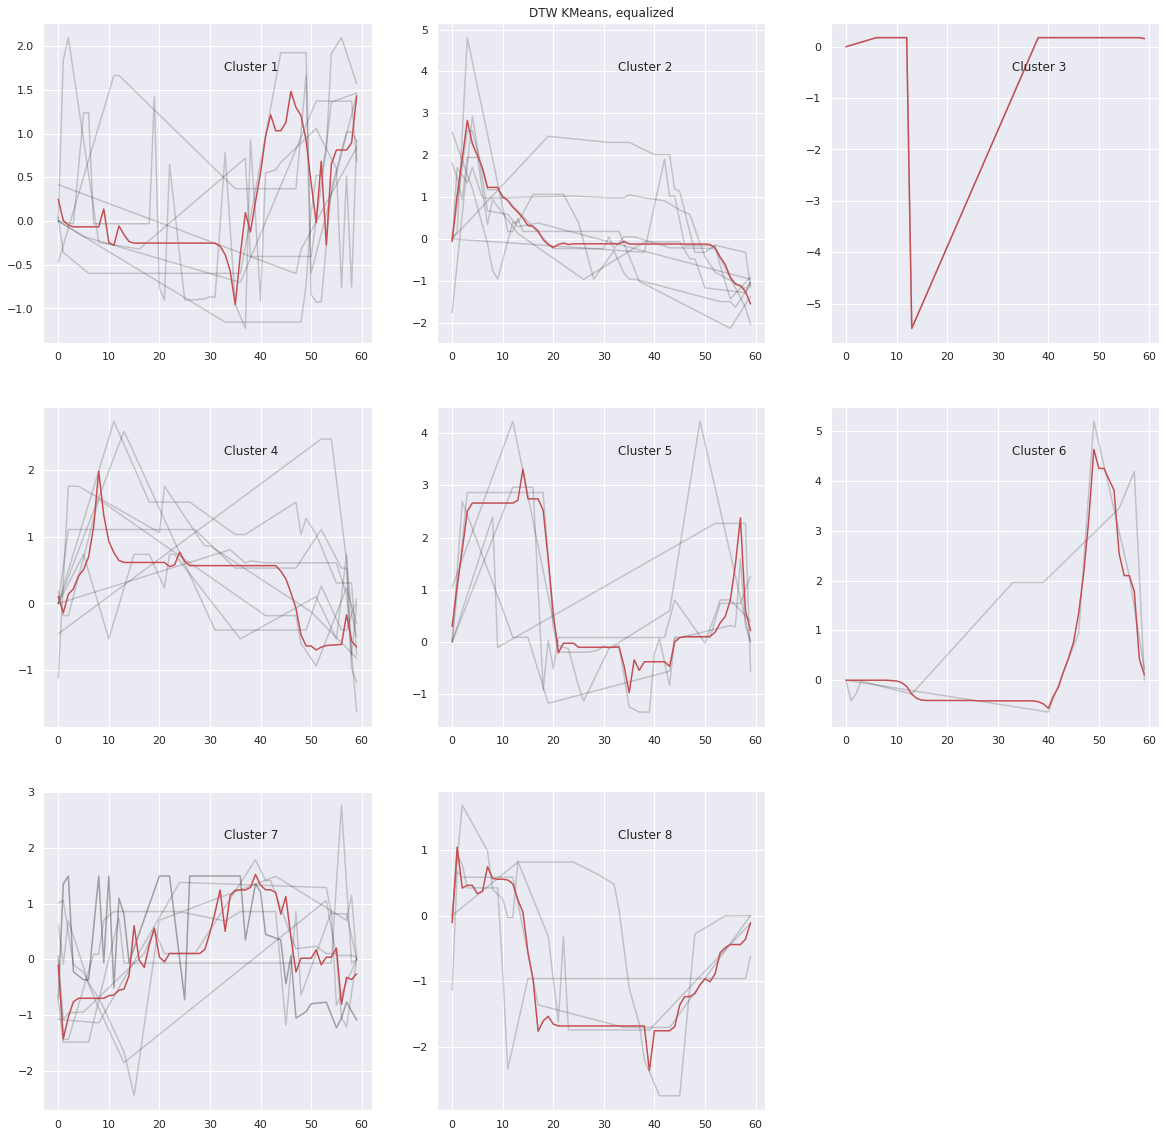

In [21]:
km, y_pred = KMeans(train, n, "dtw", n_init, SEED)
km_prep, y_pred_prep = KMeans(train_prep, n, "dtw", n_init, SEED)

visualize_clusters(km, train, y_pred, title="DTW KMeans, not equalized")
visualize_clusters(km_prep, train_prep, y_pred_prep, title="DTW KMeans, equalized")

# Kernel KMeans - cosine

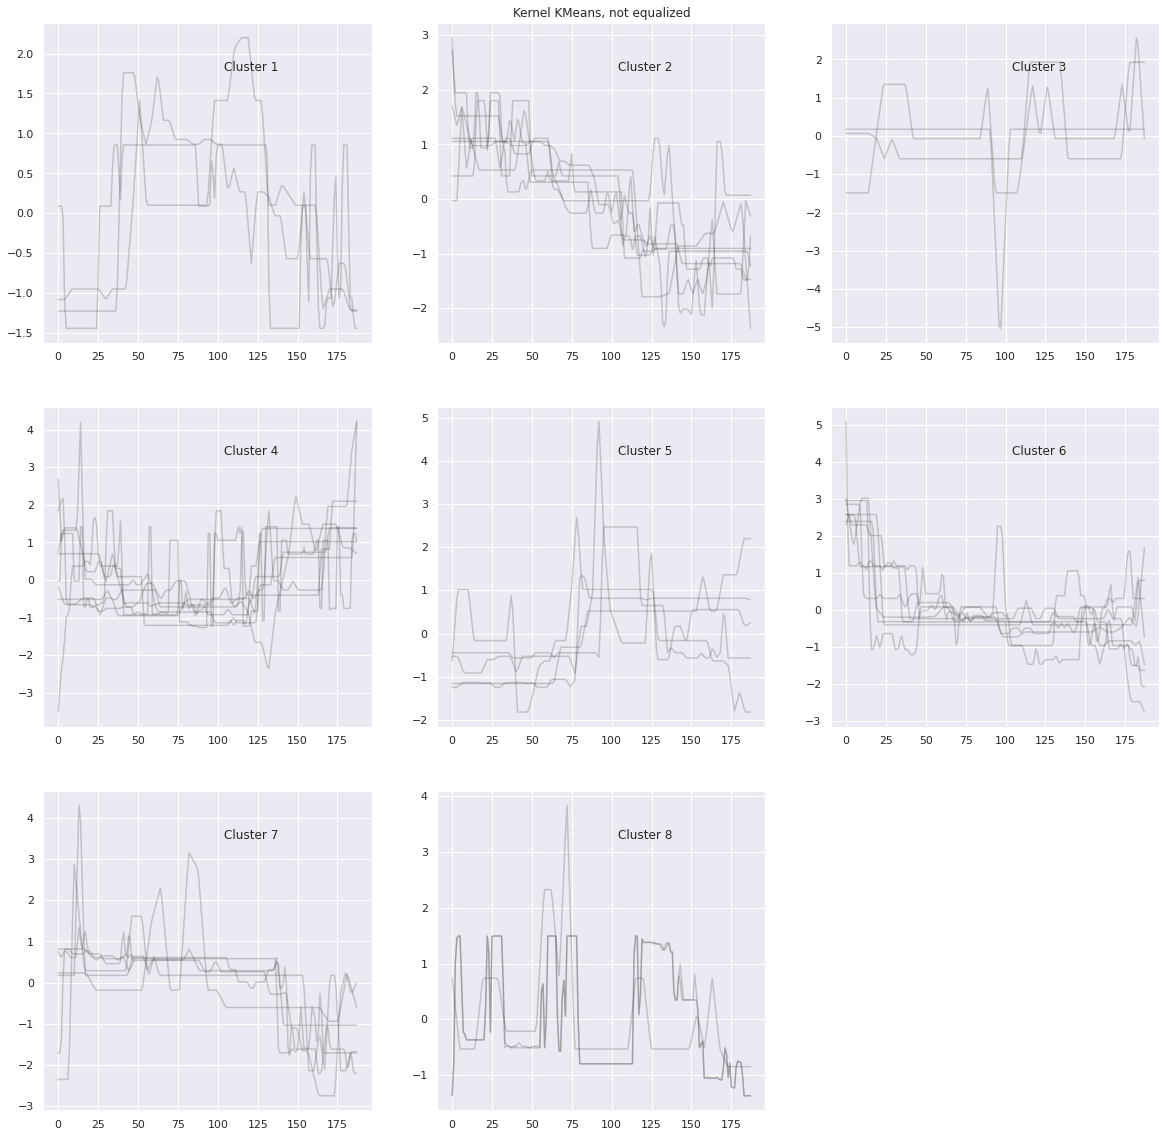

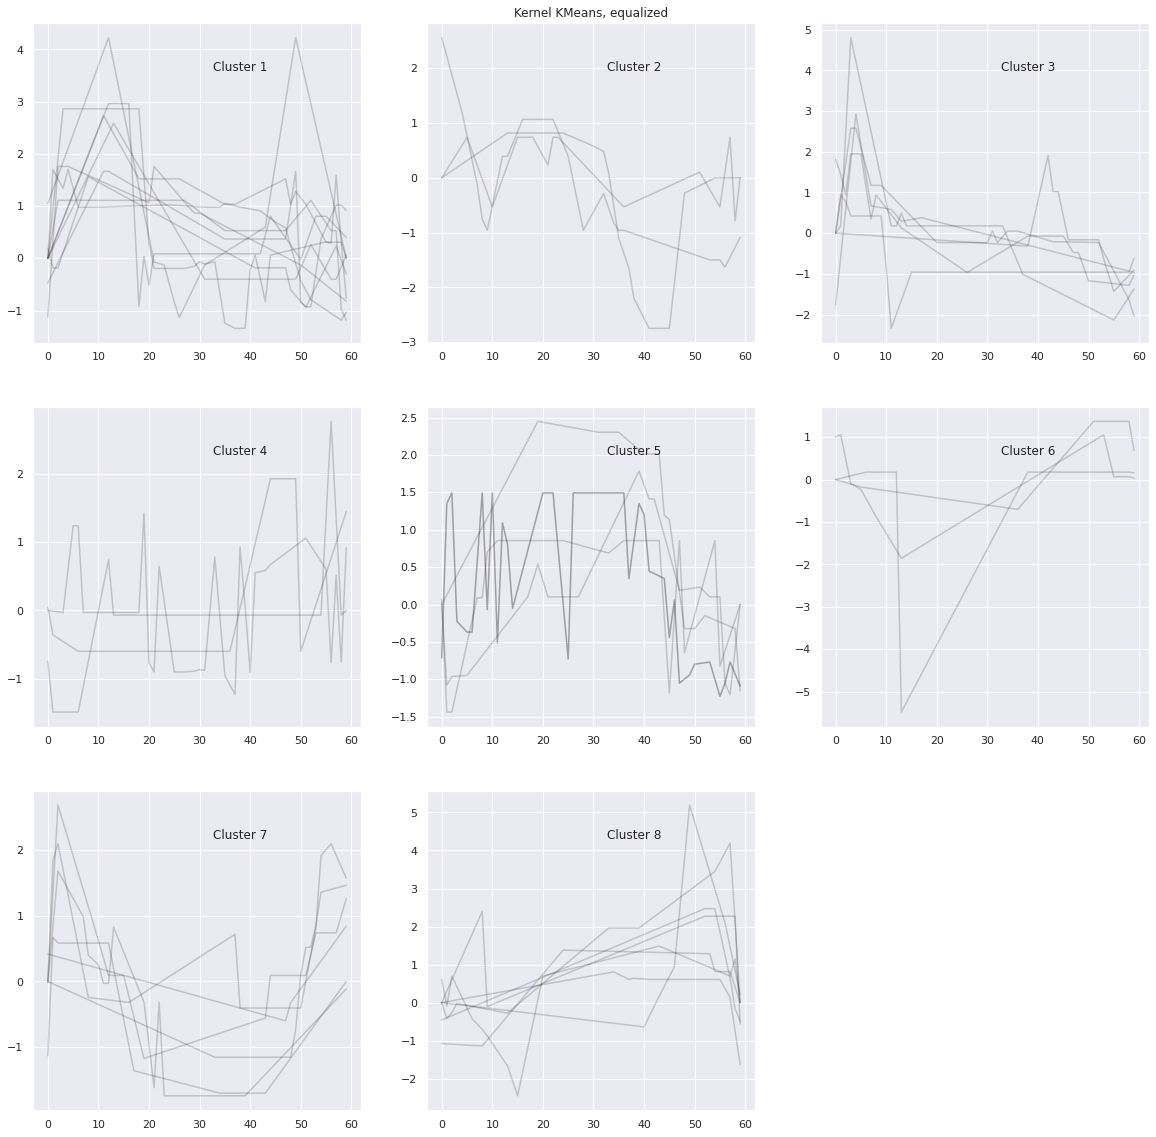

In [22]:
km, y_pred = MyKernelKMeans(train, n, "cosine", n_init, SEED)
visualize_kernel_kmeans(km, train, y_pred, title="Kernel KMeans, not equalized")

km, y_pred = MyKernelKMeans(train_prep, n, "cosine", n_init, SEED)
visualize_kernel_kmeans(km, train_prep, y_pred, title="Kernel KMeans, equalized")

По итогу, все это, конечно, очень здорово, но, как мне кажется, во-первых данных довольно мало в смысле уникальности сессий, во-вторых, сами данные не понятно как собраны, почему есть существенные вылезания за пределы временной сессии и т.п.

Здесь я оставил более или менее что-то похожее на правду, но даже такое не выдерживает критики.

Хотя, например, у KernelKMeans с косинусным ядром, субъективно, в рамках кластеров похожие тренды.

А вообще без выравнивания через пандас с интерполяцией выглядит намного лучше, т.е. кластеры, кажется, действительно разумные и получились похожие "колбасы" трендов.

Посмотри, что будет, если рассматривать сделки только в рамках какой-то платформы.

# Platform specific clustering

## Config

In [23]:
feature = "price_norm"
n = 6
n_init = 10

## Data preparation

In [24]:
platform_1 = data[data.platform_id == 1]
platform_2 = data[data.platform_id == 2]

platform_1_prep = data_prep[data_prep.platform_id == 1]
platform_2_prep = data_prep[data_prep.platform_id == 2]

In [25]:
ts = []
for session_id, values in platform_1.groupby("session_id")[feature]:
    if values.shape[0] > 1:
        ts.append(values.tolist())
    
train_1 = to_time_series_dataset(ts)
train_1 = TimeSeriesResampler(sz=train_1.shape[1]).fit_transform(train_1)

train_1_eucl = np.nan_to_num(train_1, 0)

In [26]:
ts = []
for session_id, values in platform_2.groupby("session_id")[feature]:
    if values.shape[0] > 1:
        ts.append(values.tolist())
    
train_2 = to_time_series_dataset(ts)
train_2 = TimeSeriesResampler(sz=train_2.shape[1]).fit_transform(train_2)

train_2_eucl = np.nan_to_num(train_2, 0)

In [27]:
ts = []
for session_id, values in platform_1_prep.groupby("session_id")[feature]:
    ts.append(values.tolist())
    
train_1_prep = to_time_series_dataset(ts)

In [28]:
ts = []
for session_id, values in platform_2_prep.groupby("session_id")[feature]:
    ts.append(values.tolist())
    
train_2_prep = to_time_series_dataset(ts)

## Clustering

### Euclidean

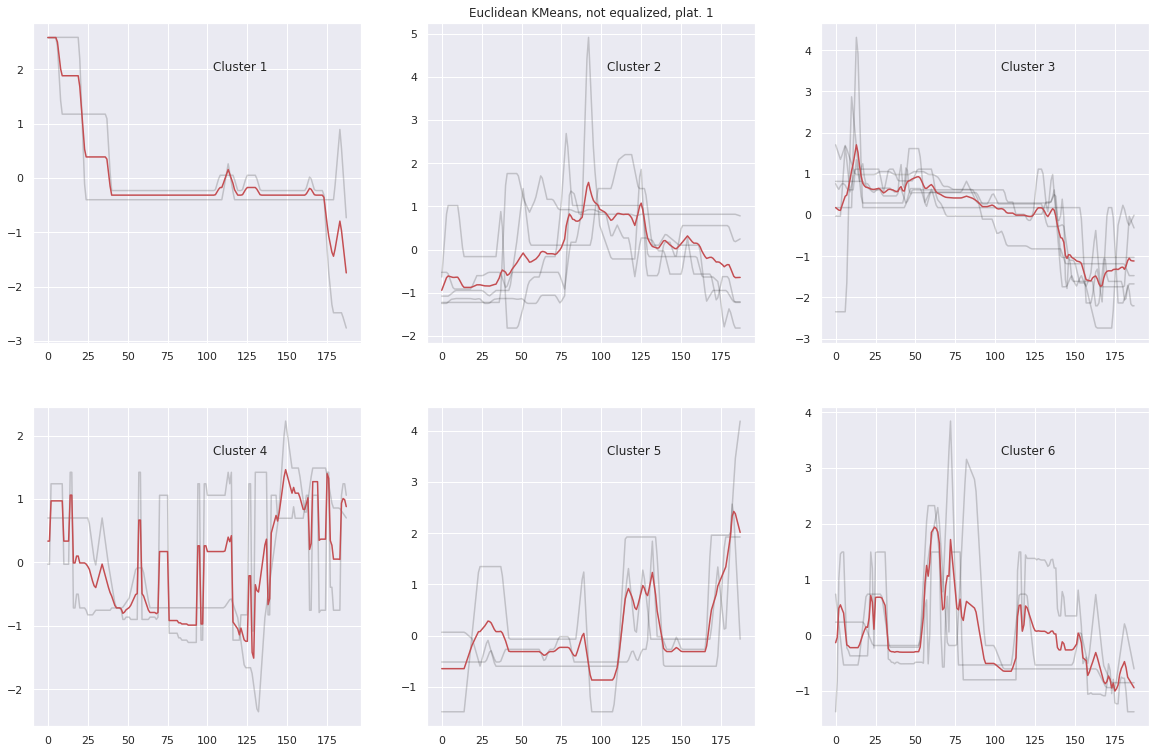

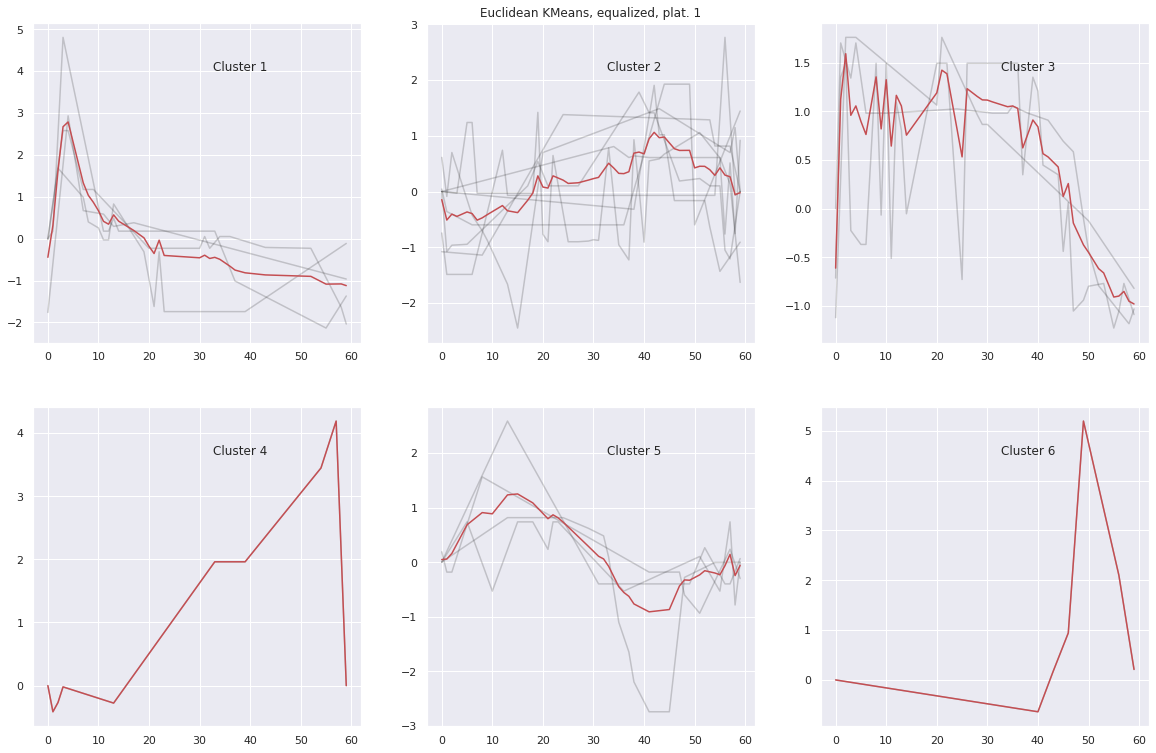

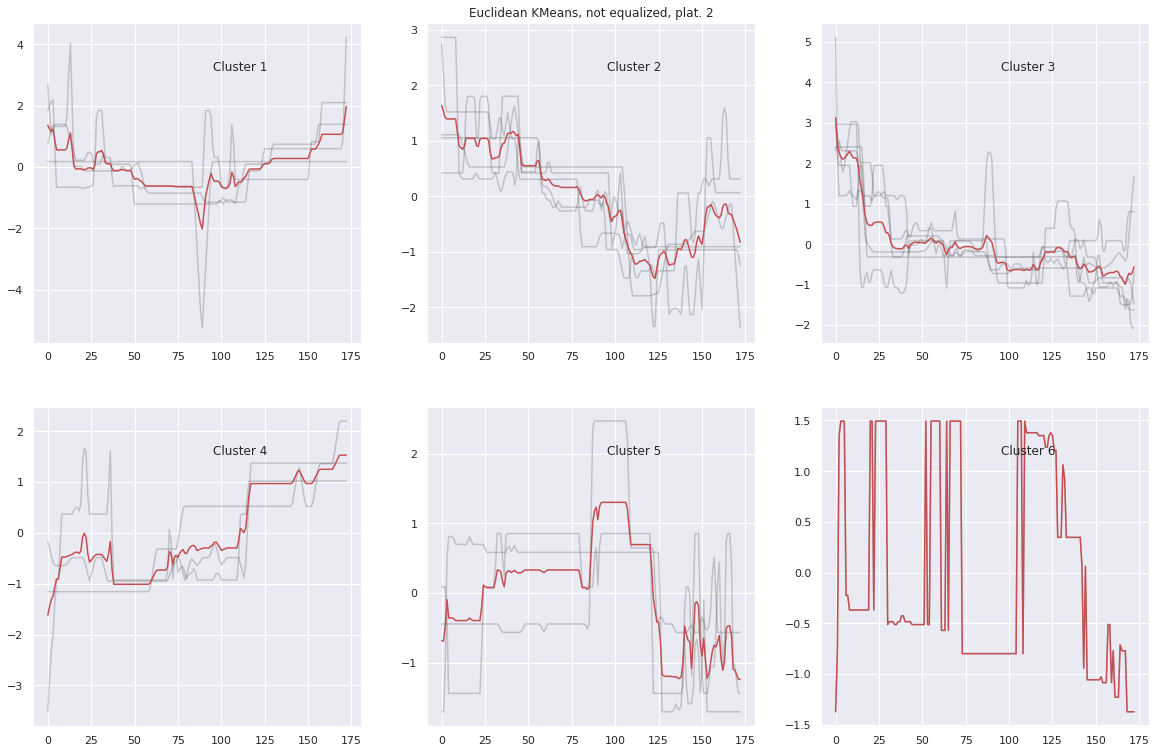

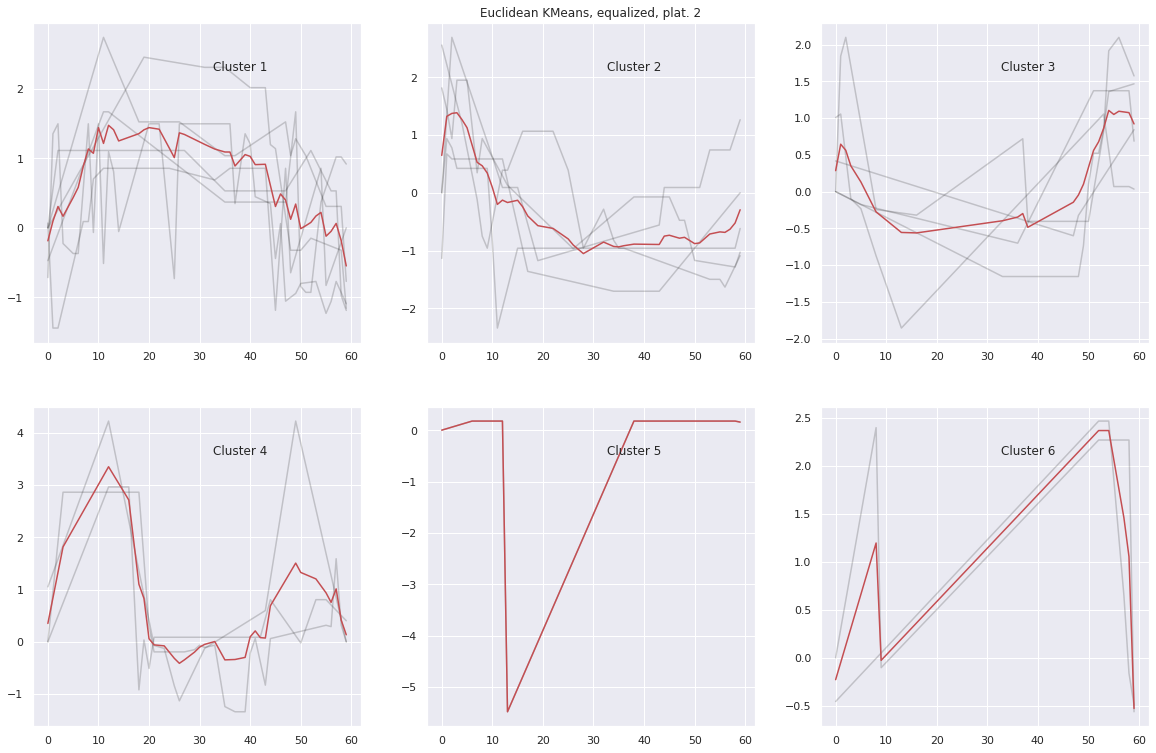

In [29]:
km, y_pred = KMeans(train_1_eucl, n, "euclidean", n_init, SEED)
visualize_clusters(km, train_1_eucl, y_pred, title="Euclidean KMeans, not equalized, plat. 1")
km, y_pred = KMeans(train_1_prep, n, "euclidean", n_init, SEED)
visualize_clusters(km, train_1_prep, y_pred, title="Euclidean KMeans, equalized, plat. 1")

km, y_pred = KMeans(train_2_eucl, n, "euclidean", n_init, SEED)
visualize_clusters(km, train_2_eucl, y_pred, title="Euclidean KMeans, not equalized, plat. 2")
km, y_pred = KMeans(train_2_prep, n, "euclidean", n_init, SEED)
visualize_clusters(km, train_2_prep, y_pred, title="Euclidean KMeans, equalized, plat. 2")

### DTW

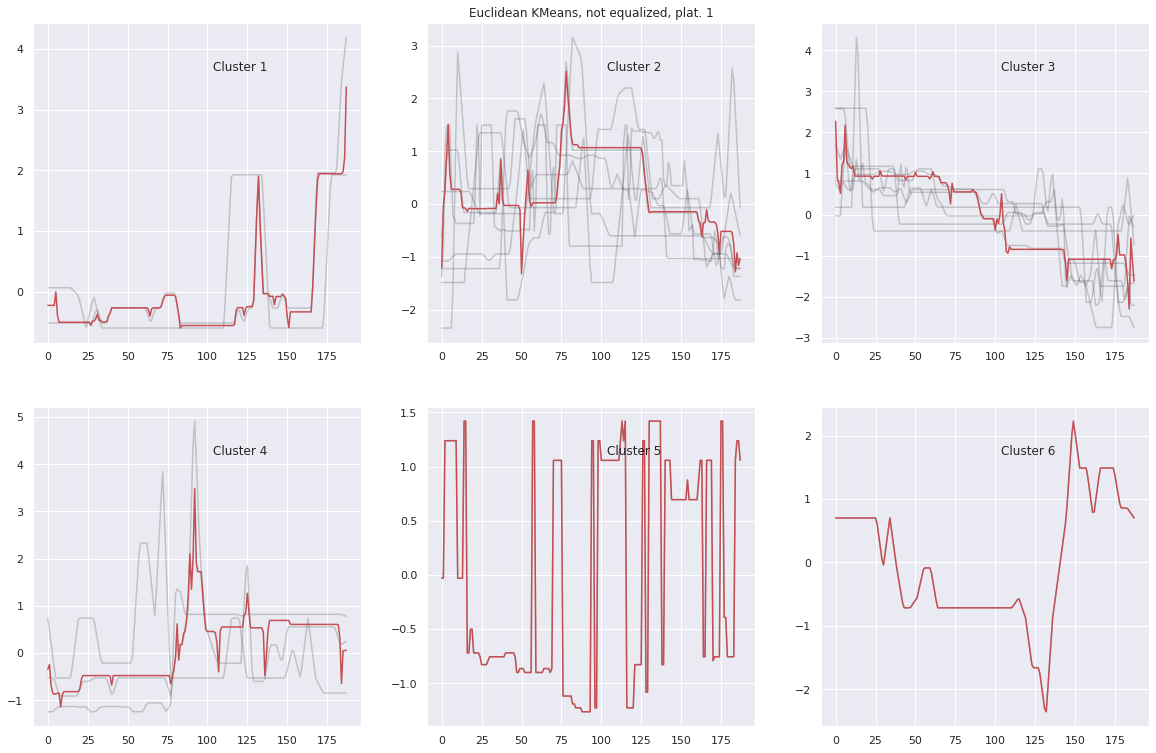

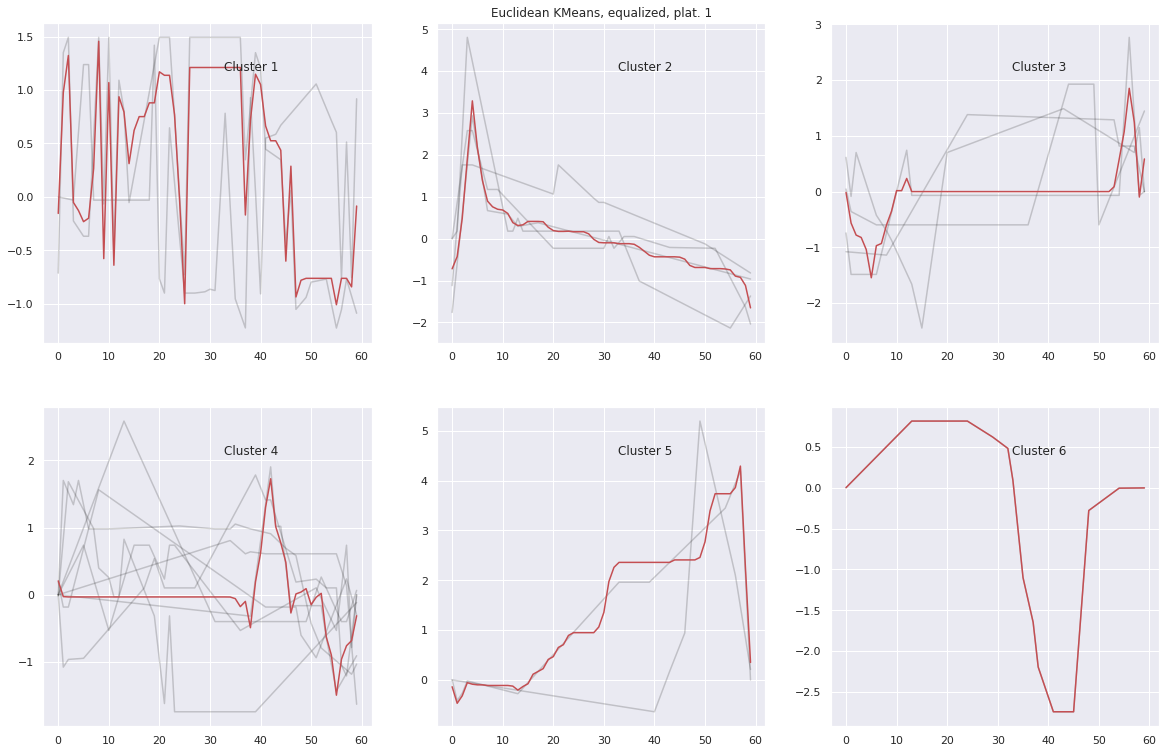

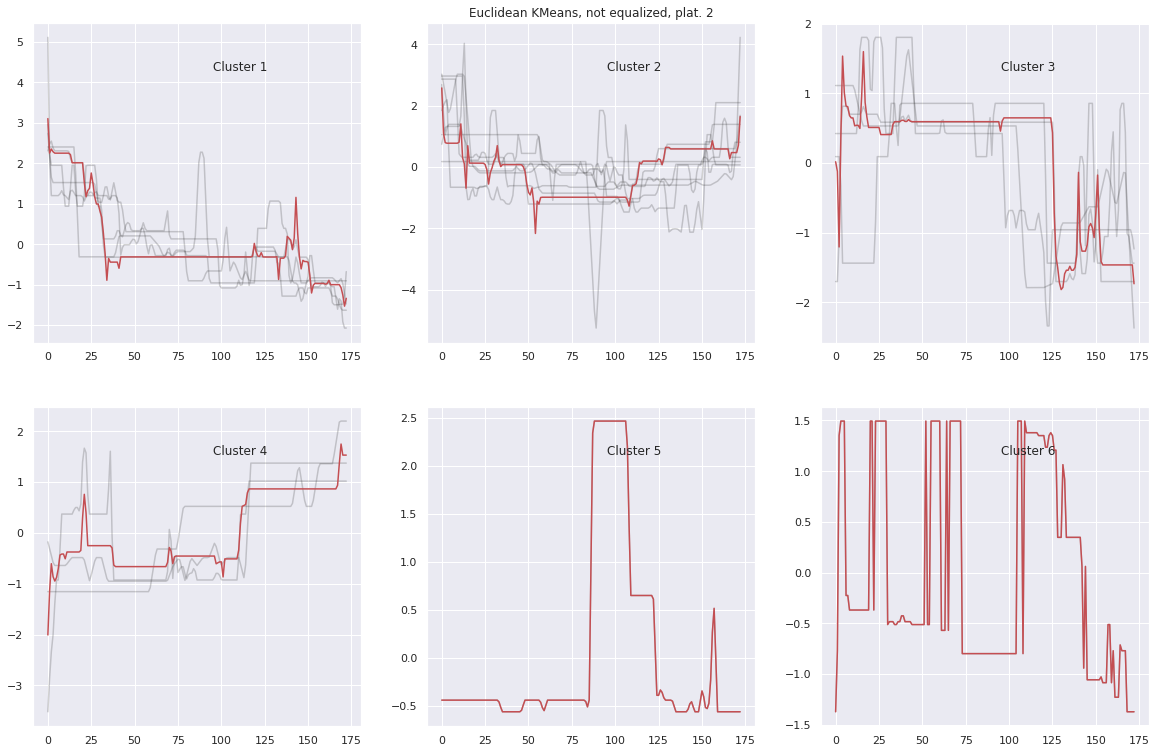

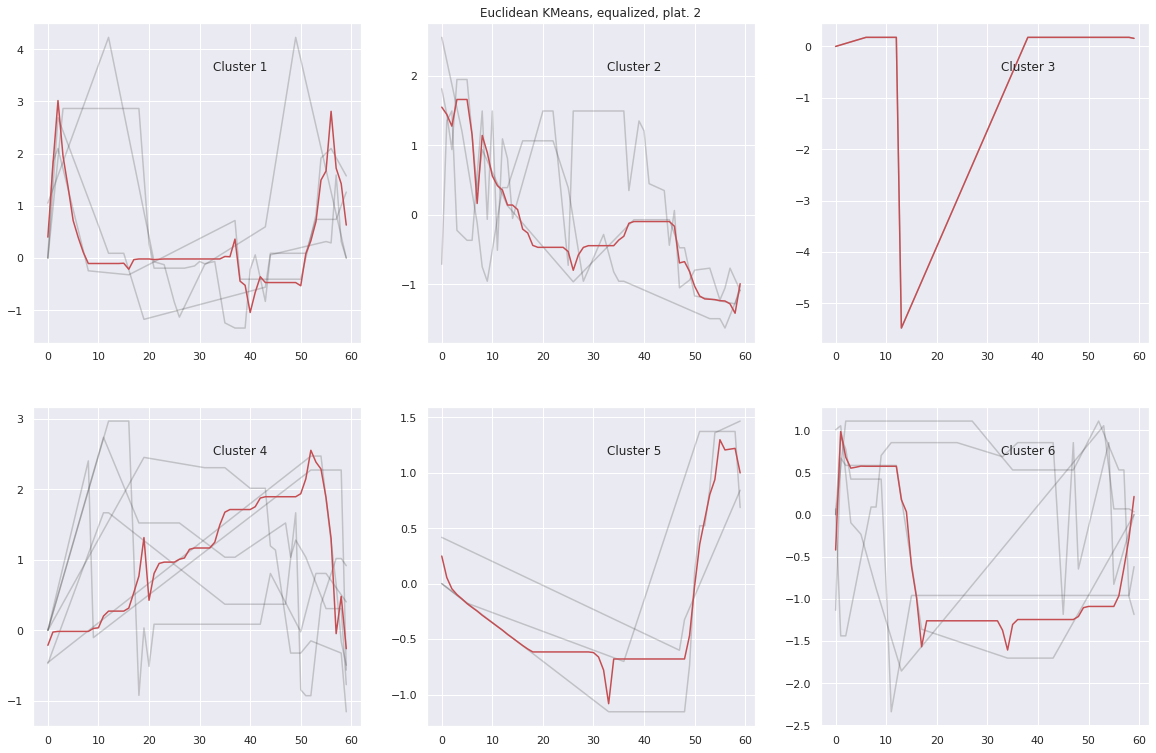

In [30]:
km, y_pred = KMeans(train_1_eucl, n, "dtw", n_init, SEED)
visualize_clusters(km, train_1_eucl, y_pred, title="Euclidean KMeans, not equalized, plat. 1")
km, y_pred = KMeans(train_1_prep, n, "dtw", n_init, SEED)
visualize_clusters(km, train_1_prep, y_pred, title="Euclidean KMeans, equalized, plat. 1")

km, y_pred = KMeans(train_2_eucl, n, "dtw", n_init, SEED)
visualize_clusters(km, train_2_eucl, y_pred, title="Euclidean KMeans, not equalized, plat. 2")
km, y_pred = KMeans(train_2_prep, n, "dtw", n_init, SEED)
visualize_clusters(km, train_2_prep, y_pred, title="Euclidean KMeans, equalized, plat. 2")

### KernelKMeans - cosine

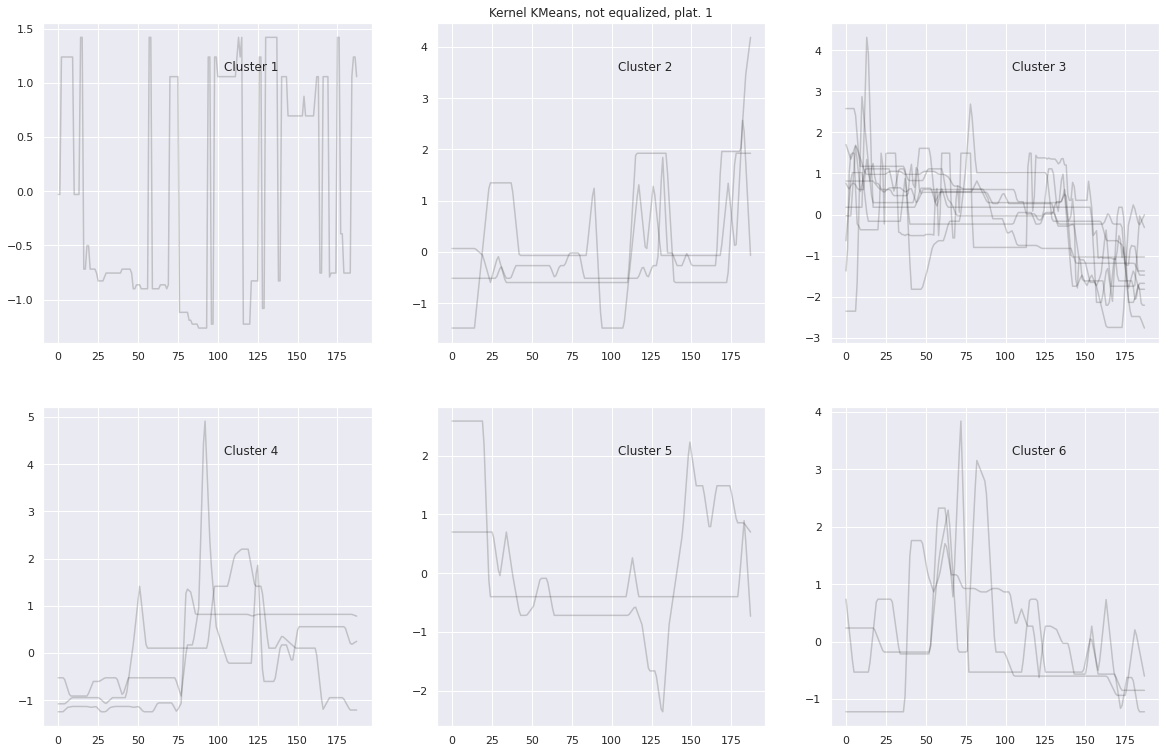

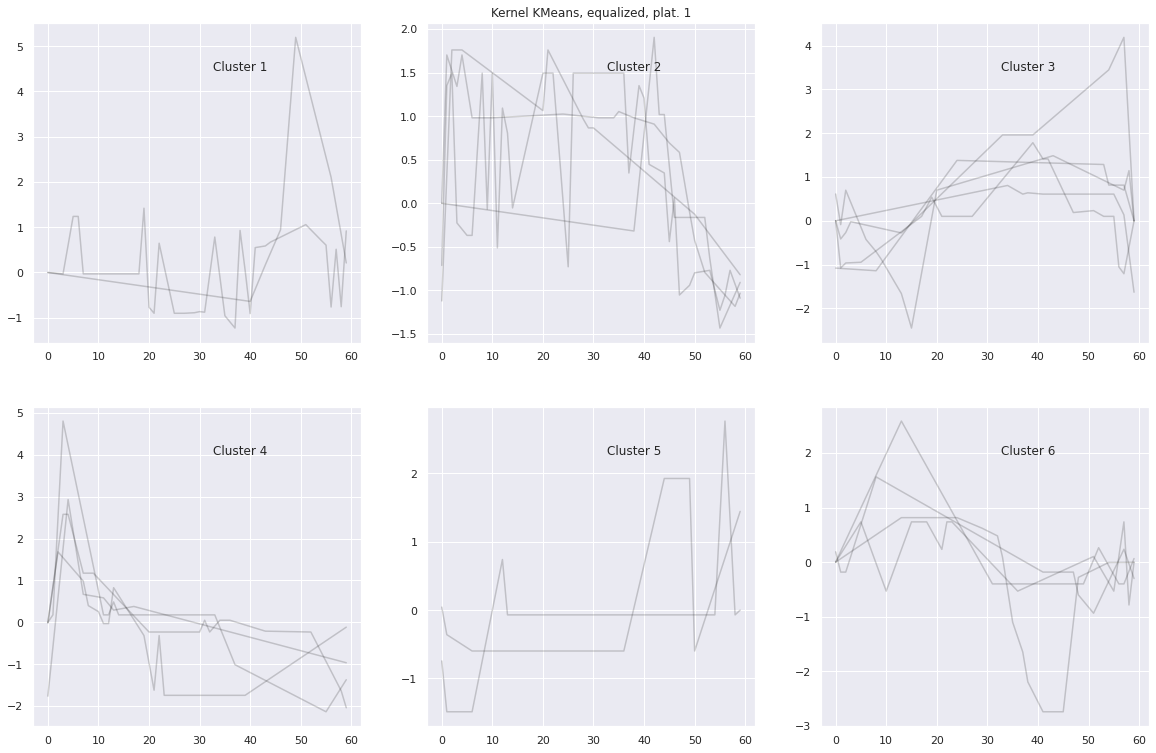

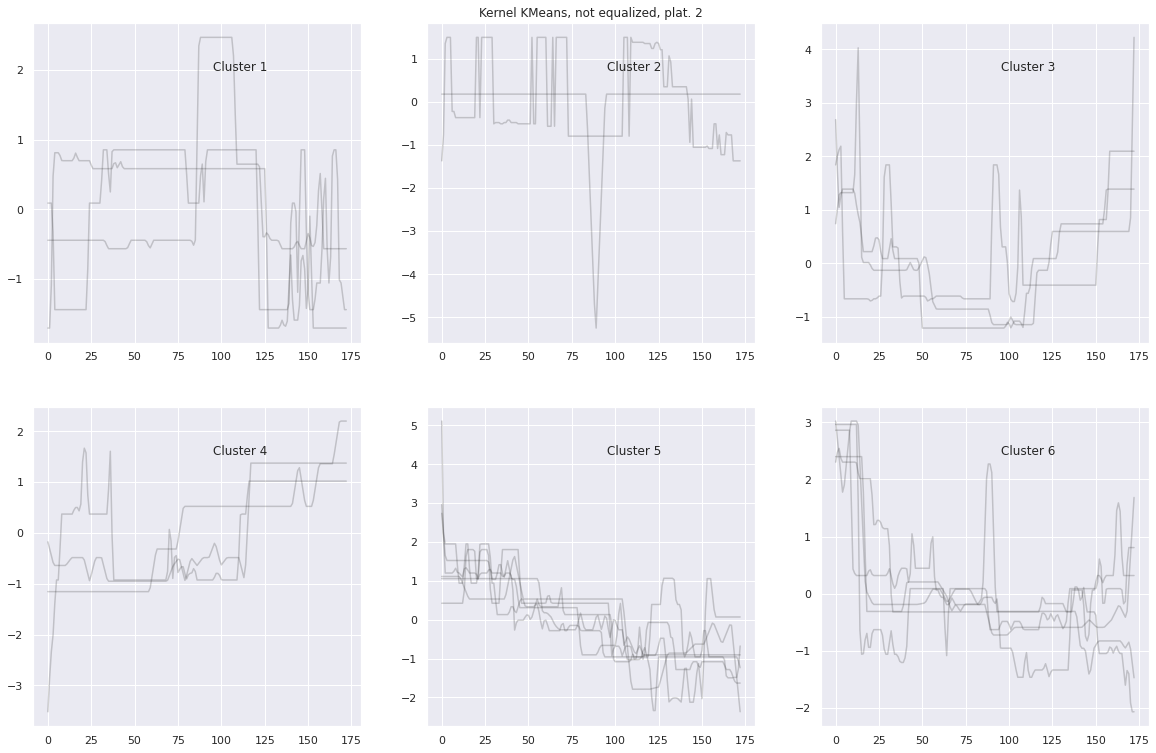

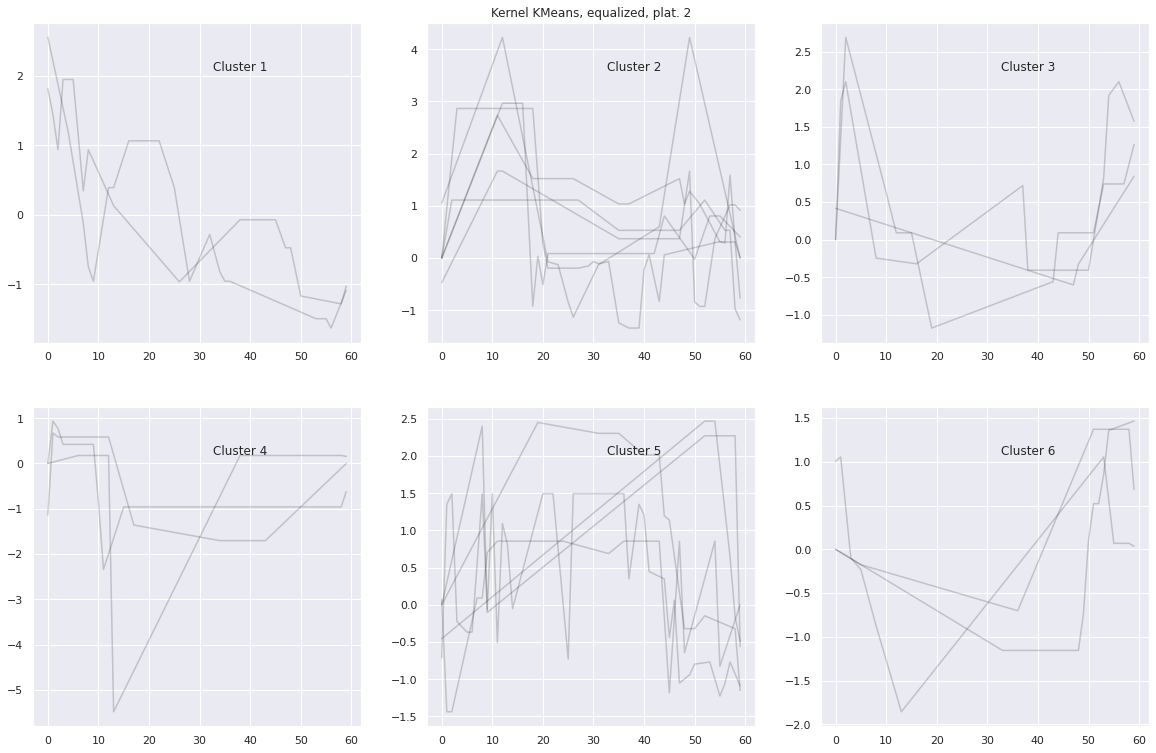

In [31]:
km, y_pred = MyKernelKMeans(train_1, n, "cosine", n_init, SEED)
visualize_kernel_kmeans(km, train_1, y_pred, title="Kernel KMeans, not equalized, plat. 1")
km, y_pred = MyKernelKMeans(train_1_prep, n, "cosine", n_init, SEED)
visualize_kernel_kmeans(km, train_1_prep, y_pred, title="Kernel KMeans, equalized, plat. 1")

km_prep, y_pred_prep = MyKernelKMeans(train_2, n, "cosine", n_init, SEED)
visualize_kernel_kmeans(km_prep, train_2, y_pred_prep, title="Kernel KMeans, not equalized, plat. 2")
km, y_pred = MyKernelKMeans(train_2_prep, n, "cosine", n_init, SEED)
visualize_kernel_kmeans(km, train_2_prep, y_pred, title="Kernel KMeans, equalized, plat. 2")

# Еще вывод

В целом, если разделить платформы, то получается, конечно, лучше. Вероятно, для выравненных сессий какой-нибудь DBSCAN показал бы хорошие результаты.

В целом, даже эвклидова метрика показывает нестыдный результат (местами тот же DTW, кажется, хуже)